**Import Necessary Libraries**

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

**Define Functions for Model and Data Preperation**

In [56]:
def create_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape),
        Dropout(0.1),

        Bidirectional(LSTM(units=50, return_sequences=False)),
        Dropout(0.1),

        Dense(units=25), 
        Dense(units=1)
    ])

    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: custom_weighted_loss(y_true, y_pred))
    return model

In [57]:
def custom_weighted_loss(y_true, y_pred):
    weights = tf.range(1, tf.shape(y_true)[0] + 1, dtype=tf.float32)
    weights = tf.math.exp(weights / tf.reduce_max(weights))
    loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return tf.reduce_mean(loss * weights)

In [58]:
def prepare_data(df, sequence_length=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i - sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

**Load and Prepare the Data**

In [59]:
def load_stock_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    return df

df = load_stock_data('../data/nvidia_stock.csv')
X, y, scaler = prepare_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) 

**Callbacks for Training Stability**

In [60]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6 , verbose=1) 
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

**Train the LSTM model**

In [61]:
model = create_lstm_model(input_shape=(X_train.shape[1], 1))
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1 , callbacks=[reduce_lr, early_stop])

Epoch 1/100


c:\Users\athar\anaconda3\envs\data_science\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 2.9327e-04 - val_loss: 2.6895e-05 - learning_rate: 0.0010
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 1.3106e-06 - val_loss: 3.5034e-05 - learning_rate: 0.0010
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 7.5095e-07 - val_loss: 3.3828e-05 - learning_rate: 0.0010
Epoch 4/100
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 6.5383e-07
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 6.5311e-07 - val_loss: 3.5936e-05 - learning_rate: 0.0010
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 6.1364e-07 - val_loss: 2.5797e-05 - learning_rate: 5.0000e-04
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 6.4647e-07 - val_loss: 2.5242e-05 - learning_rate: 5.0000e-04
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.1669e-07
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
73/73 ━━━━━━━━

**Visualize Training History**

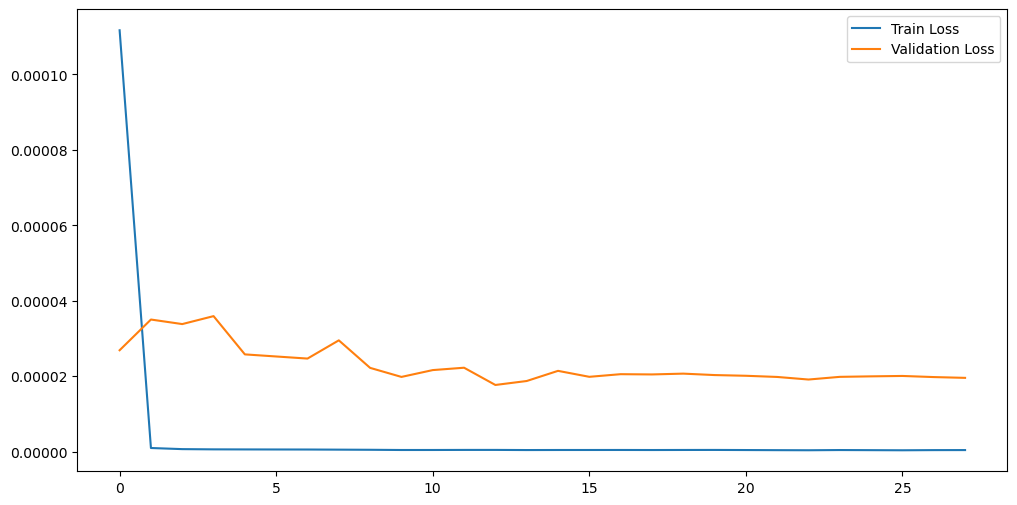

In [62]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

**Evaluate Model Performance**

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Mean Squared Error: 24.29251101791269


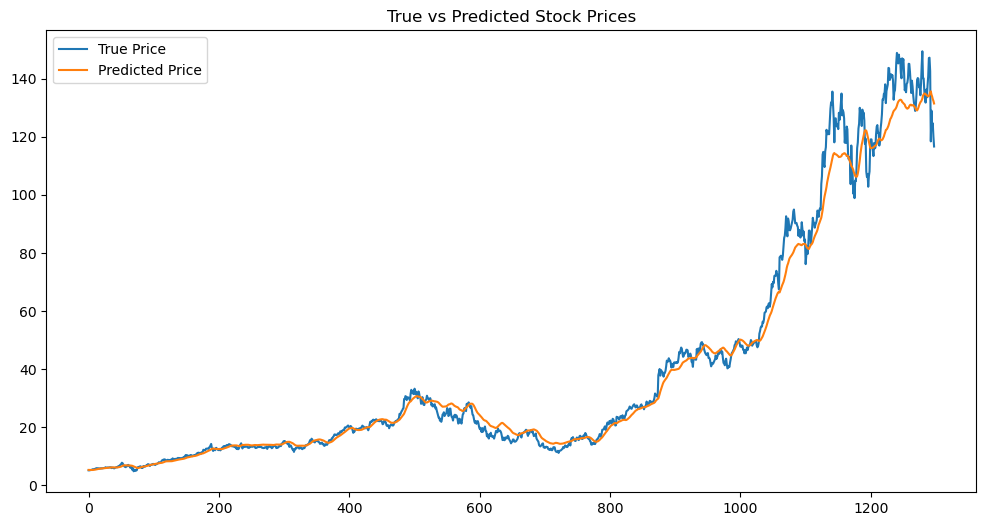

24.29251101791269

In [63]:
def evaluate_model_with_debugging(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  

    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  

    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')

    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='True Price')
    plt.plot(predictions, label='Predicted Price')
    plt.title('True vs Predicted Stock Prices')
    plt.legend()
    plt.show()

    return mse

evaluate_model_with_debugging(model, X_test, y_test, scaler)